In [1]:
wd <- dirname(dirname(getwd()))

In [2]:
source(paste0(wd,"/mission_control/treasure_map.R"))

In [3]:
suppressMessages(library(tidyverse))
suppressMessages(library(RobustRankAggreg))
suppressMessages(library(cluster))
suppressMessages(library(ggrepel))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpubr))
library(grid)

Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”

### 0 - Read in Data for Silhouette

In [4]:
#Download exhaustive results and RNA data
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
threshold <- -log10(ingredients$by_05_fdr)[1]
ready <- readRDS(paste0(I_DIR, "cpi_go.Rds"))

### 1 - Calculate Silhouette Scores HMF

In [5]:
#select significant features from BOR analysis
##only RNA features
##only genes (no genesets, no cybersort)
##only with positive correlation
bor_rna<-ingredients %>% filter(model == "bor", dataset == "all", covariates == "age_biopsy_purity_tissue", p_val <= by_05_fdr,big_group=="RNA", Group == "Gene") %>% arrange(p_val)
bor_rna<-bor_rna %>% filter(!grepl('tmb|tcell|pretreat|tgfb|prolif', feature))
bor_rna<-bor_rna %>% filter(plot_est >= 1)
nrow(bor_rna)

[1] 48

In [6]:
#select significant features from OS residuals analysis
##only RNA features
##only genes (no genesets, no cybersort)
##with correlation less than 0.5 with tmb, pretreat and tcell
os_resid_rna <- ingredients %>% filter(model == "os", dataset == "all", covariates == "residuals",p_val <= by_05_fdr) 
os_resid_rna <- os_resid_rna %>% filter(cor_pretreat < 0.5, cor_tmb < 0.5, cor_tcell < 0.5)
os_resid_rna <- os_resid_rna %>% filter(big_group=="RNA", Group == "Gene")
os_resid_rna <- os_resid_rna %>% filter(!grepl('tmb|tcell|pretreat|tgfb|prolif', feature))
nrow(os_resid_rna)

[1] 50

In [7]:
#small function to calculate distances from correlations
calc_dist <- function(cor_matrix){
    dist <- dist(sqrt(1 - abs(cor_matrix)))
    return(dist)
}

In [8]:
#extract RNA data for selected features, correlate them and calculate distance 
silhouette_cor_go <- ready %>% select(all_of(c(os_resid_rna$feature, bor_rna$feature)))  %>% drop_na() 
full_cor_matrix = cor(as.matrix(silhouette_cor_go))
full_dist_matrix= calc_dist(full_cor_matrix)

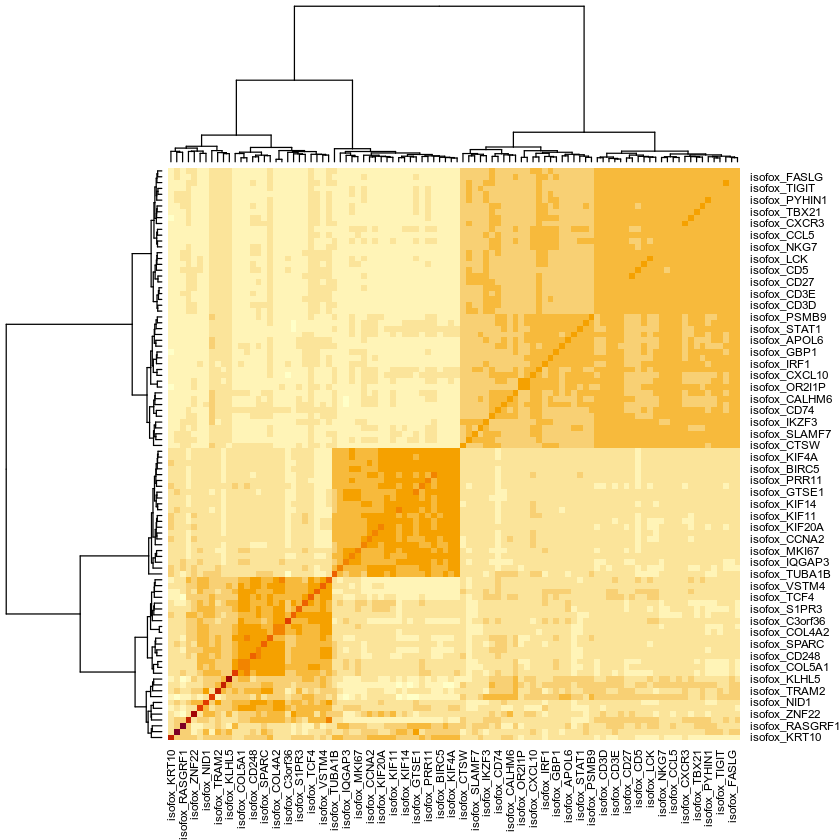

In [9]:
#visualize correlations
heatmap(full_cor_matrix, distfun = calc_dist,hclustfun = function(d) hclust(d, method = "ward.D2"))

In [10]:
#Cluster features based on correlations
full_clustering <- cutree(hclust(full_dist_matrix,method = "ward.D2"), k = 5)
table(full_clustering)

full_clustering
 1  2  3  4  5 
22 11 17 23 25 

In [11]:
#exclude features of cluster2 (those that have low correlations to everything) from correlation matrix, repeat clutering
cor_matrix_silhouette <- (full_cor_matrix[full_clustering !=2,full_clustering !=2])
dist_matrix_silhouette = calc_dist(cor_matrix_silhouette)

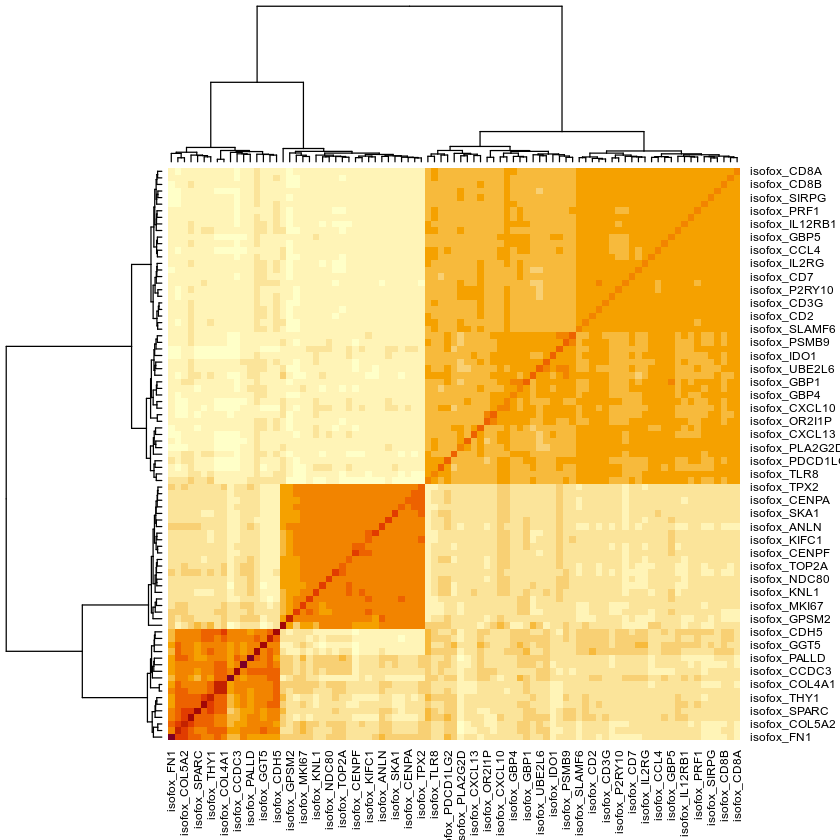

In [12]:
#visualize correlations
heatmap(cor_matrix_silhouette, distfun = calc_dist,hclustfun = function(d) hclust(d, method = "ward.D2"))

In [13]:
#cut tree in 3 clusters
clustering_silhouette <- cutree(hclust(dist_matrix_silhouette,method = "ward.D2"), k = 3)

#### 1.2 Calculate silhouette scores for HMF

In [14]:
calculate_silhuette_scores <- function(df_name, cor_matrix, clustering) {
    dist_matrix = calc_dist(cor_matrix)
    sw_cur <- silhouette(clustering, dist_matrix)
    sw_df_cur <- as.data.frame.matrix(sw_cur)
    sw_df_cur$cluster_annotated = ifelse(sw_df_cur$cluster == 1, "proliferation", ifelse(sw_df_cur$cluster == 2, "tgfb", "tcell"))
    sw_df_cur$gene = colnames(cor_matrix)
    sw_df_cur$dataset = df_name
    if (df_name == "HMF"){
        sw_df_cur$gene_name = apply(sw_df_cur, 1, function(x) str_split(x[5], "_")[[1]][2])
        }else(
        sw_df_cur$gene_name = sw_df_cur$gene
    )
    return(sw_df_cur) 
}

In [15]:
sw_df <- as.data.frame(calculate_silhuette_scores("HMF", cor_matrix_silhouette, clustering_silhouette))

In [16]:
#order genes by decrease of silhuette score
gene_levels = sw_df[order(sw_df$sil_width),]$gene_name

### 2 - Calculate Silhouette External Datasets

In [17]:
setwd(REF_DIR)

In [18]:
#Download RNA data for other datasets
hmf_df <- readRDS('rna_hmf.Rds')   ### log-transformed
inspire_df <- readRDS('rna_inspire.Rds') ### some transformation
mariathasan_df <- readRDS('rna_mariathasan.Rds')  ### raw
parker_df <- readRDS('rna_parker.Rds') ### raw - probably log or log2 transformed
ravi_df <- readRDS('rna_ravi.Rds')  ### ravi - raw?
lyon_df <- readRDS('rna_lyon.Rds')  ### log2 transformations

In [19]:
#Function to calculate silhuette scores in external datasets 
#Clustering is the same as in HMF dataset!!!
calculate_silhuette_scores_external <- function(df_name, df, hmf_silhuette_result){
    if (df_name == "mariathasan"|df_name == "ravi"){
        df = log(df+1)}
    silhouette_cor_go_cur <- df %>% select(any_of(hmf_silhuette_result$gene_name))  %>% drop_na() 
    cor_matrix_silhouette_cur = cor(as.matrix(silhouette_cor_go_cur))
    dist_matrix_silhouette_cur = calc_dist(cor_matrix_silhouette_cur)
    cor_matrix_silhouette_cur_df = as.data.frame(cor_matrix_silhouette_cur)
    cor_matrix_silhouette_cur_df$gene_name = rownames(cor_matrix_silhouette_cur_df)
    cur_clustering = merge(cor_matrix_silhouette_cur_df[,c("CCDC3","gene_name")],hmf_silhuette_result[,c("gene_name", "cluster","cluster_annotated")], by="gene_name" , sort=FALSE)
    cur_result <- calculate_silhuette_scores(df_name, cor_matrix_silhouette_cur, cur_clustering$cluster)
    return(cur_result)
}

In [20]:
#calculate silhouettes in external datasets 
sw_df_mariathasan <- calculate_silhuette_scores_external("mariathasan", mariathasan_df, sw_df)
sw_df_parker <- calculate_silhuette_scores_external("parker", parker_df, sw_df)
sw_df_ravi <- calculate_silhuette_scores_external("ravi", ravi_df, sw_df)
sw_df_inspire <- calculate_silhuette_scores_external("inspire", inspire_df, sw_df)

In [21]:
#merge results
result = rbind(sw_df, sw_df_mariathasan)
result = rbind(result, sw_df_parker)
result = rbind(result, sw_df_ravi)
result = rbind(result, sw_df_inspire)
head(result)

cluster,neighbor,sil_width,cluster_annotated,gene,dataset,gene_name
1,2,0.6862313,proliferation,isofox_ANLN,HMF,ANLN
1,2,0.7114402,proliferation,isofox_BIRC5,HMF,BIRC5
2,1,0.4555776,tgfb,isofox_C3orf36,HMF,C3orf36
2,1,0.5498738,tgfb,isofox_CCDC3,HMF,CCDC3
1,2,0.6772596,proliferation,isofox_CCNA2,HMF,CCNA2
2,1,0.6282437,tgfb,isofox_CD248,HMF,CD248


In [22]:
#vizualize silhouette values in different datasets ()
plot_boxplot<-(ggplot(result, aes(x=dataset, y=sil_width, fill=cluster_annotated))
     + geom_boxplot() 
     + facet_wrap(~factor(cluster_annotated, levels = c("tcell","proliferation","tgfb")))
    + theme_bw()
    + scale_fill_manual(values = c("#8DD3C7", "#FB8072", "#BEBADA"),name="")
    + theme(legend.position = "none")
)
#plot_boxplot

#### 2.2 Consistency of silhouette values in external datasets

In [23]:
# Merge silhouette results for all datasets in one table for ranking analysis
for_ranking = merge(sw_df, sw_df_mariathasan[,c(7,3)], by="gene_name", all=TRUE, suffixes = c(".HMF", ".mariathasan"))
for_ranking = merge(for_ranking, sw_df_parker[,c(7,3)], by="gene_name", all=TRUE)
colnames(for_ranking)[ncol(for_ranking)]<-"sil_width.parker"
for_ranking = merge(for_ranking, sw_df_ravi[,c(7,3)], by="gene_name", all=TRUE)
colnames(for_ranking)[ncol(for_ranking)]<-"sil_width.ravi"
for_ranking = merge(for_ranking, sw_df_inspire[,c(7,3)], by="gene_name", all=TRUE)
colnames(for_ranking)[ncol(for_ranking)]<-"sil_width.inspire"

In [24]:
# Subset RNA clusters (t-cell, proliferation and tgfb) as we want to make ranking separately in each cluster
for_ranking_tcell = for_ranking[for_ranking$cluster_annotated == "tcell",]
for_ranking_prolif = for_ranking[for_ranking$cluster_annotated == "proliferation",]
for_ranking_tgfb = for_ranking[for_ranking$cluster_annotated == "tgfb",]

In [25]:
#function for aggregation of ranks 
#uses "aggregateRanks" function from "aggregateRanks" package
aggregate_external_ranks <- function(input_df){
    input_df$rank.mariathasan <- rank(input_df$sil_width.mariathasan, na.last="keep")
    input_df$rank.parker <- rank(input_df$sil_width.parker, na.last="keep")
    input_df$rank.ravi <- rank(input_df$sil_width.ravi, na.last="keep")
    input_df$rank.inspire <- rank(input_df$sil_width.inspire, na.last="keep")
    ranked_list_mariathasan <- input_df$gene_name[!is.na(input_df$rank.mariathasan)][order(-input_df$rank.mariathasan[!is.na(input_df$rank.mariathasan)])]
    ranked_list_parker <- input_df$gene_name[!is.na(input_df$rank.parker)][order(-input_df$rank.parker[!is.na(input_df$rank.parker)])]
    ranked_list_ravi <-input_df$gene_name[!is.na(input_df$rank.ravi)][order(-input_df$rank.ravi[!is.na(input_df$rank.ravi)])]
    ranked_list_inspire <-input_df$gene_name[!is.na(input_df$rank.inspire)][order(-input_df$rank.inspire[!is.na(input_df$rank.inspire)])]
    glist<-list(ranked_list_mariathasan,ranked_list_parker,ranked_list_ravi,ranked_list_inspire)
    merged_ranks<-aggregateRanks(glist = glist, N = nrow(input_df), full=FALSE, method = "stuart")
    result=merge(merged_ranks, input_df, by.x="Name", by.y="gene_name")
    result$n_sets_present = apply(result, 1, function(a) {4-sum(is.na(a[c("sil_width.mariathasan","sil_width.parker","sil_width.inspire","sil_width.ravi")]))})
    return(result)
}

In [26]:
#aggregate ranks in each cluster
#column "Score" contains aggregated scores
merged_ranks_tcell <- aggregate_external_ranks(for_ranking_tcell)
merged_ranks_prolif <- aggregate_external_ranks(for_ranking_prolif)
merged_ranks_tgfb <- aggregate_external_ranks(for_ranking_tgfb)

In [27]:
#merge results for all cluaters in one table
merged_ranks <- rbind(merged_ranks_tcell,merged_ranks_prolif)
merged_ranks <- rbind(merged_ranks, merged_ranks_tgfb)
merged_ranks$Name = as.vector(merged_ranks$Name)

#### 2.3 Create illustrative plot for aggregation of ranks on tgfb cluster example

In [28]:
#select two example genes
merged_ranks_tgfb$color = ifelse(merged_ranks_tgfb$Name == "THY1", "high", ifelse(merged_ranks_tgfb$Name == "GGT5", "low", "other"))

In [29]:
#sort gene names in each dataset by silhouette values within dataset
HMF_sort = merged_ranks_tgfb[order(merged_ranks_tgfb$sil_width.HMF,na.last=F),]$Name
inspire_sort = merged_ranks_tgfb[order(merged_ranks_tgfb$sil_width.inspire,na.last=F),]$Name
mariathasan_sort = merged_ranks_tgfb[order(merged_ranks_tgfb$sil_width.mariathasan,na.last=F),]$Name
parker_sort = merged_ranks_tgfb[order(merged_ranks_tgfb$sil_width.parker,na.last=F),]$Name
ravi_sort = merged_ranks_tgfb[order(merged_ranks_tgfb$sil_width.ravi,na.last=F),]$Name
score_sort = merged_ranks_tgfb[order(-merged_ranks_tgfb$Score,na.last=F),]$Name

In [30]:
#function to plot silhouette values in each dataset sorted by silhuette values
plot_sil_dataset <- function(title, df_name, df_merged_ranks, sort_vector){
    plot <- (ggplot(df_merged_ranks, 
                    aes(x=factor(Name, levels = sort_vector),
                        y=get(paste("sil_width", df_name, sep=".")), 
                        fill=color)) 
    + geom_bar(stat = "identity") 
    + scale_alpha_manual(values = c(1,0.5))
    + theme_bw(base_size = 24) + theme(plot.title = element_text(hjust = .5), plot.margin = margin(0,0,0,0, "cm"))
    + coord_flip()
    + xlab("")
    + ylab("Silhouette score")
    + theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text.y=element_text(size=10),axis.text.x=element_text(size=10), axis.title.x=element_text(size=16),
            legend.position = "none",plot.title = element_text(size = 20))
    + scale_fill_manual(values = c("#a29adb","#BEBADA","lightgrey"))
    + ggtitle(title)
)
    return(plot)
}

In [31]:
#plot silhouette values in each dataset and aggregated scores
p_hmf <- plot_sil_dataset("HMF CPI", "HMF", merged_ranks_tgfb, HMF_sort)
p_inspire <- plot_sil_dataset("INSPIRE", "inspire", merged_ranks_tgfb, inspire_sort)
p_mariathasan <- plot_sil_dataset("MARIATHASAN", "mariathasan", merged_ranks_tgfb, mariathasan_sort)
p_parker <- plot_sil_dataset("PARKER-ICI", "parker", merged_ranks_tgfb, parker_sort)
p_ravi <- plot_sil_dataset("RAVI", "ravi", merged_ranks_tgfb, ravi_sort)

p_agg<-(ggplot(merged_ranks_tgfb, aes(x=factor(Name, levels = score_sort),y=-log10(Score), fill=color)) 
    + geom_bar(stat = "identity") 
    + scale_alpha_manual(values = c(1,0.5))
    + theme_bw() + theme(plot.title = element_text(hjust = .5), plot.margin = margin(0,0,0,0, "cm"))
    + coord_flip()
    + xlab("")
    + ylab("silhuette score")
    + theme(, panel.grid.major = element_blank(),panel.grid.minor = element_blank(), 
            axis.text.y=element_text(size=10),axis.text.x=element_text(size=10), axis.title.x=element_text(size=16),
            legend.position = "none",plot.title = element_text(size = 18))
    + scale_fill_manual(values = c("#a29adb","#BEBADA","lightgrey"))
    + ylab("Aggregate Score")
    + ggtitle("Rank aggregation")
)

In [32]:
img <- png::readPNG(RCurl::getURLContent("https://openclipart.org/image/400px/113191"), native = FALSE)
arrow_logo <- rasterGrob(img, width = unit(1,"npc"), height=unit(0.2,"npc"))

In [33]:
#aggregated plot
sil_aggragetion<-arrangeGrob(p_hmf, p_inspire, p_mariathasan, p_parker, p_ravi, arrow_logo, p_agg, nrow=1, widths=c(1,1,1,1,1,0.2,1))

Warning message:
“Removed 1 rows containing missing values (position_stack).”

In [34]:
#p_inspire

#### 2.4 Plot silhouette scores in HMF against aggragated scores

In [35]:
merged_ranks$color_high = ifelse(merged_ranks$cluster_annotated == "tcell", "#f55b49", ifelse(merged_ranks$cluster_annotated == "prolifereation", "#3dccb4","#a29adb"))
merged_ranks$color_low = ifelse(merged_ranks$cluster_annotated == "tcell", "#FB8072", ifelse(merged_ranks$cluster_annotated == "prolifereation", "#8DD3C7","#BEBADA"))

In [36]:
name_map <- list("tcell" = "T-cell", "tgfb" = "TGFB", "proliferation" = "Proliferation")
mapper <- function(i) name_map[[i]]
merged_ranks <- merged_ranks %>% rowwise() %>% mutate(cluster_annotated = factor(mapper(cluster_annotated), levels = c("T-cell", "TGFB", "Proliferation")))

In [37]:
feature_color_map <- list(
    "T-cell" = '#FB8072',
    "TGFB" = "#BEBADA",
    "Proliferation" = "#8DD3C7"
)

In [38]:
ranks_agg_plot<-(ggplot(merged_ranks, aes(y=-log10(Score), x=sil_width.HMF, col=cluster_annotated))#, alpha = -log(Score))) 
    + geom_point(size = 5) 
    + facet_wrap(~factor(cluster_annotated, levels = c("T-cell","TGFB", "Proliferation")), scales = "free")
    + theme_bw(base_size = 24)
    + ylab("Aggregate Score")
    + xlab("Silhouette score in HMF CPI Study")
    + geom_text_repel(aes(label = ifelse(Score <= 0.01, Name, "")), size=6, col="grey20", alpha=1 ,max.overlaps=Inf,box.padding = 0.2)
    #+ geom_text(aes(label = ifelse(Score <= 0.015, Name, "")), size=3, col="grey20", alpha=1)             
    + scale_color_manual(values = unlist(feature_color_map))
    + scale_alpha_continuous(range = c(0.3, 1))
    + theme(legend.position="none", panel.grid.major = element_blank(),panel.grid.minor = element_blank())
)
#ranks_agg_plot

- Add color strips to panels

In [39]:
color_strips <- function(gg){
  g <- ggplot_gtable(ggplot_build(gg))
  strips <- which(grepl('strip', g$layout$name))
  pal <- c( '#FB8072', "#BEBADA", "#8DD3C7")
  for (i in seq_along(strips)) {
    k <- which(grepl('rect', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
    g$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- pal[i] 
  } 
  as_ggplot(g)
}

In [40]:
ranks_agg_plot <- color_strips(ranks_agg_plot)

### 3 - Final Silhouette figure

In [41]:
silhouette <- as_ggplot(arrangeGrob(as_ggplot(sil_aggragetion),ranks_agg_plot, layout_matrix = cbind(c(1,1,1,1,2,2,2,2,2)))) + theme(plot.title = element_text(vjust = 3, size = 24))

- GGrepel is lost when save as .Rds..

In [42]:
saveRDS( silhouette, paste0(FIG_DIR, "figure4-and-silhouettes.Rds"))

### 4 - Create Final Figure 4

In [43]:
forest_plots <- readRDS(paste0(FIG_DIR, "supplement_forest_univariate.Rds"))

In [44]:
annote <- function( i, lab ) annotate_figure( i, fig.lab = lab, fig.lab.size = 20, fig.lab.face = "bold")

In [45]:
plot_a <- annote(forest_plots  + theme(plot.margin = unit(c(0,0,2,0), "cm")), "A")
plot_b <- annote( silhouette + ggtitle("Silhouette Scores: Stability of trascriptomics-based latent factors"), "B")

In [46]:
figure7_supp <- as_ggplot(arrangeGrob(plot_a, plot_b))

In [47]:
FIG_FINAL_DIR

[1] "/workspace/projects/immune_biomarkers/final_figures/"

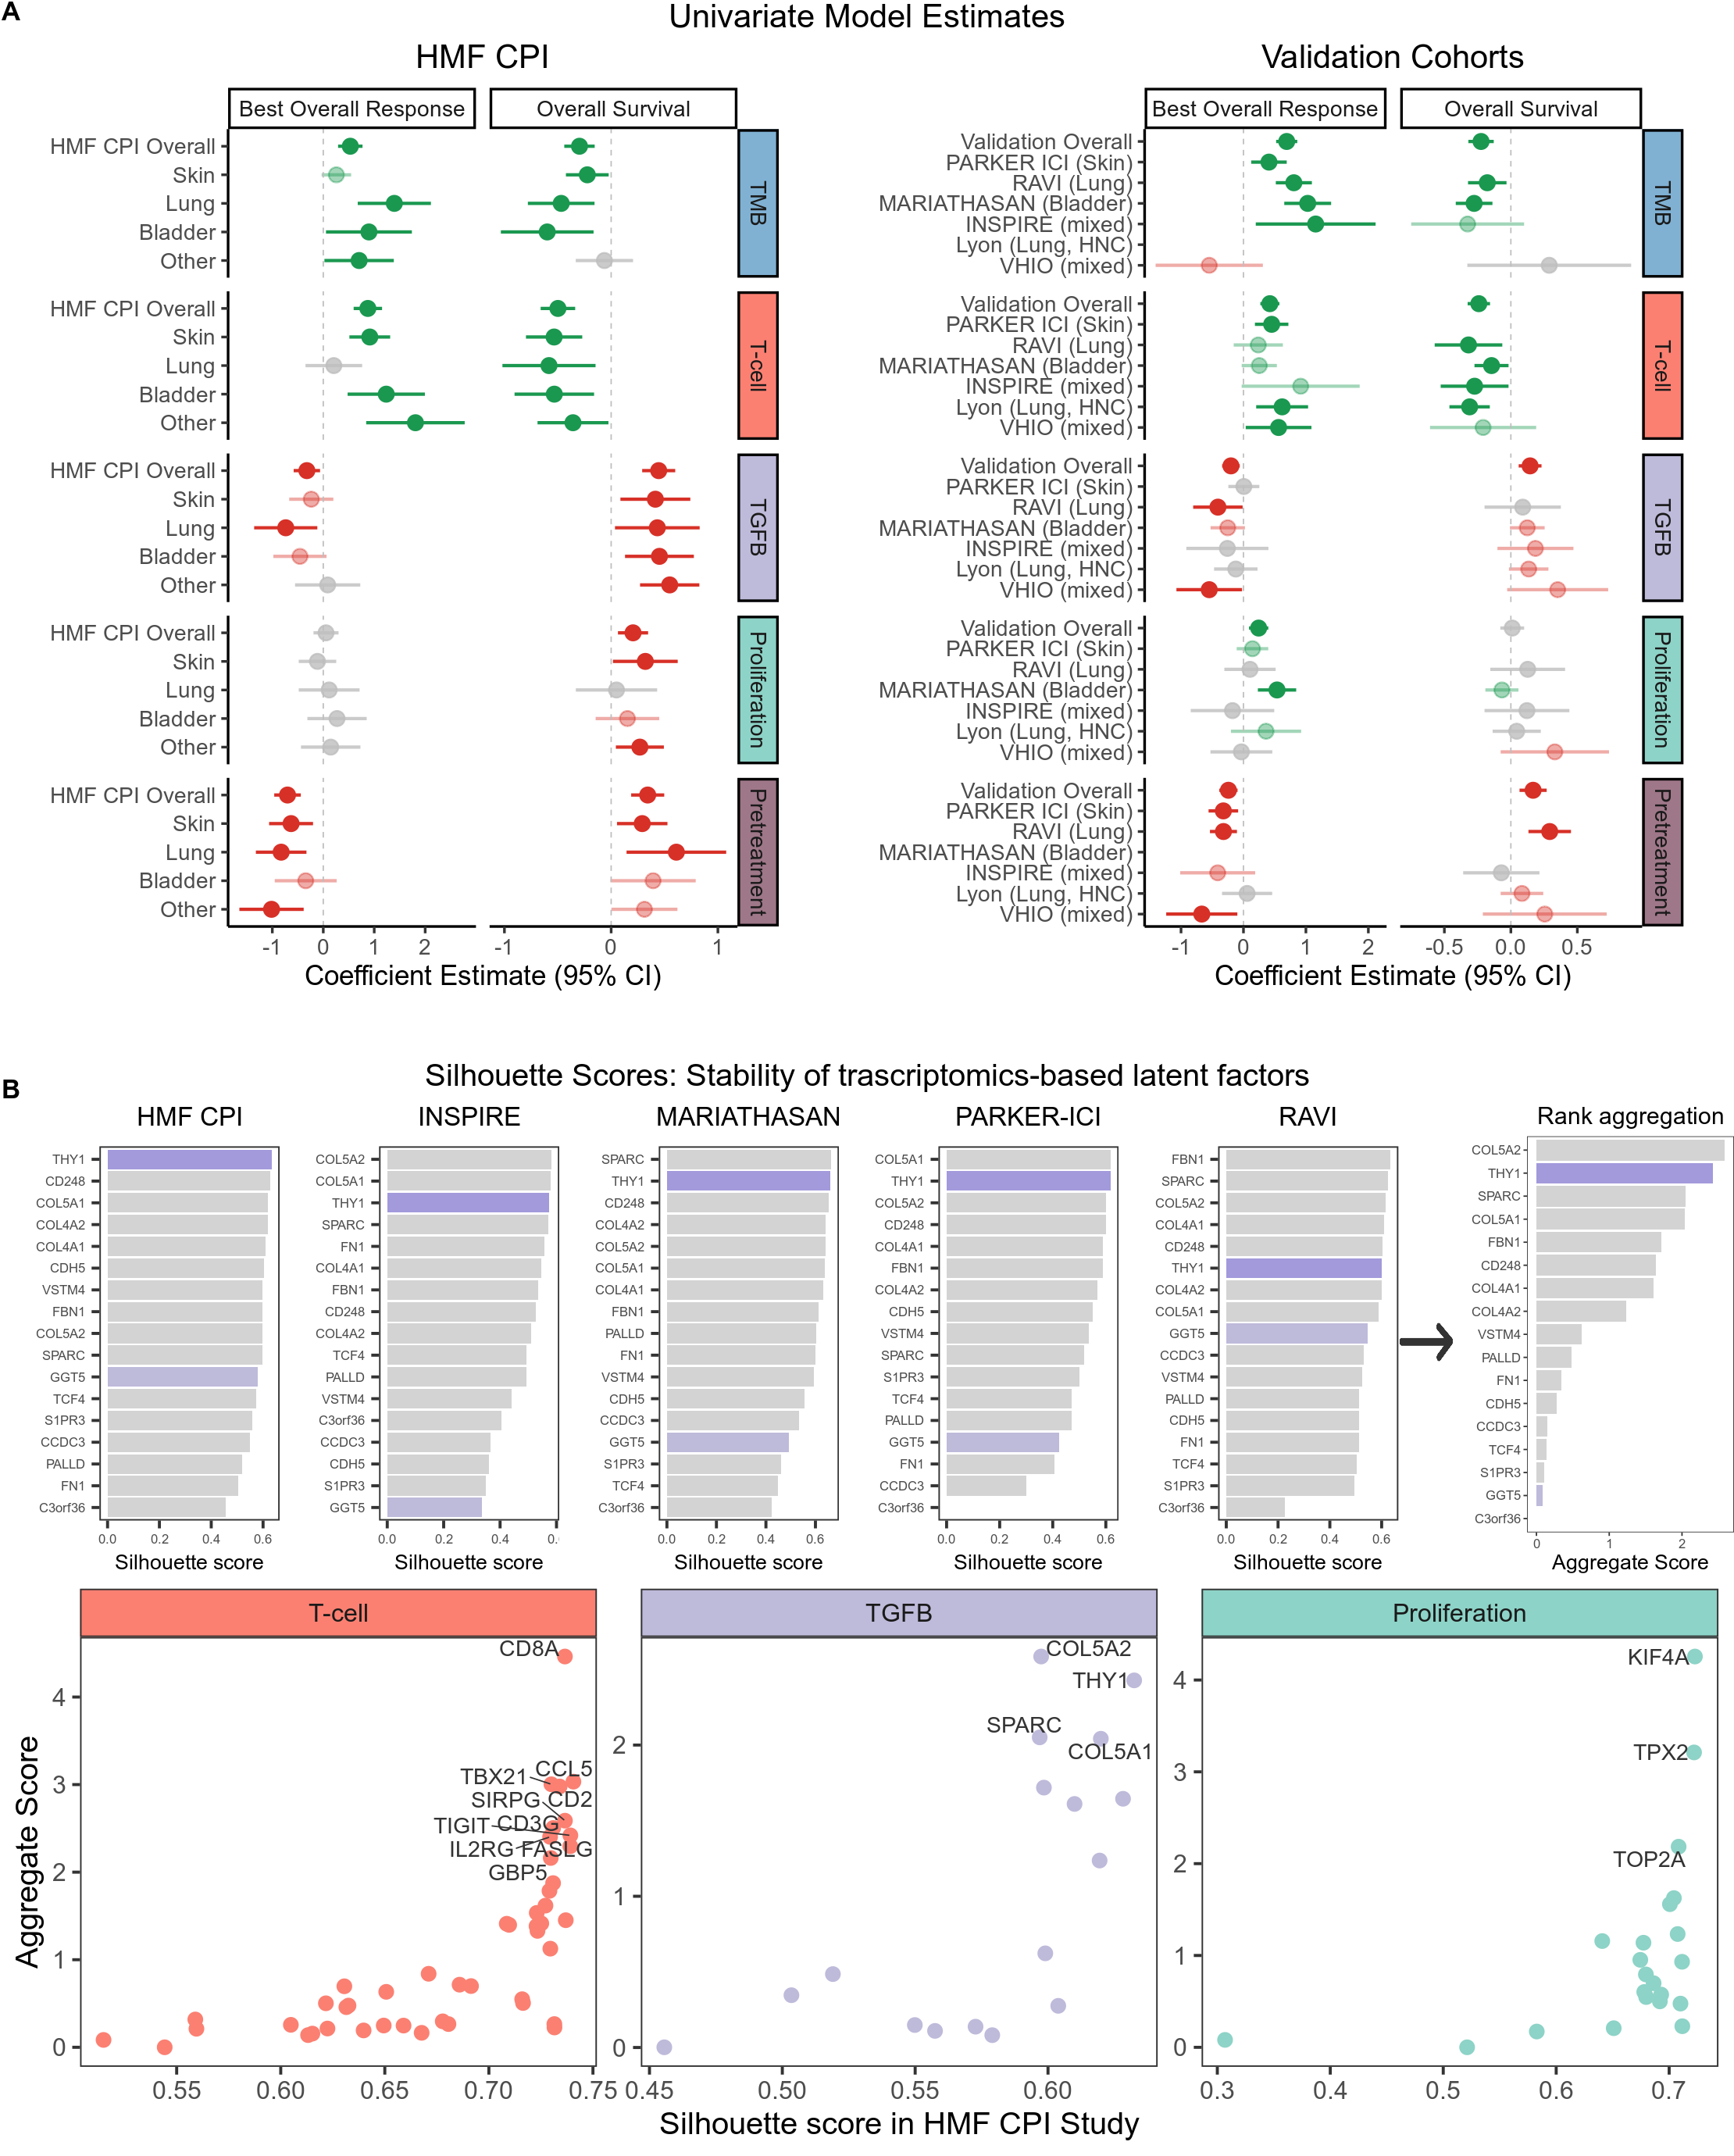

In [48]:
options(repr.plot.width = 18.5, repr.plot.height= 23, resolution = 200)
figure7_supp
ggsave( paste0(FIG_FINAL_DIR, "7_forest_plot_supp_univariate.png"), width = 18.5, height = 23, dpi = 400)
#ggsave( paste0(FIG_FINAL_DIR, "figure4.png"), width = 18.5, height = 23, dpi = 400)